In [ ]:
%load_ext autoreload
%autoreload 2

import datajoint as dj
dj.config["enable_python_native_blobs"] = True
dj.config["database.host"] = '134.2.168.16'
dj.config['schema_name'] = "nnfabrik_monkey_mei"
schema = dj.schema("nnfabrik_monkey_mei")

import os
from os import listdir
from os.path import isfile, join

import torch
import numpy as np
import pickle 
import time
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.optimize import curve_fit
from scipy.stats.distributions import vonmises

import nnfabrik
from nnfabrik import main, builder
from nnfabrik.main import *

import nnvision
from nnvision.tables.from_nnfabrik import TrainedModel
from nnvision.tables.from_nnfabrik import DataInfo

import insilico_stimuli
from insilico_stimuli.stimuli import *
from insilico_stimuli.parameters import *

In [7]:
# nnfabrik main
from nnvision.tables.main import MonkeyExperiment
from nnvision.tables.from_mei import TrainedEnsembleModel, MEIMethod
from featurevis.main import MEITemplate
from nnvision.tables.measures import OracleScore

@schema
class MEI_update(MEITemplate):
    trained_model_table = TrainedEnsembleModel
    selector_table = MonkeyExperiment.Units

In [8]:
# parameters
dataset_hash='a737408da40cfedd036c2eb1b8a31ff1'
ensemble_hash='e7a8d0b961ee37ffda0779bfed95f1cf'

data_key='3631807112901'                   

In [9]:
# get the model 
model_key = (TrainedModel * TrainedEnsembleModel.Member() & dict(ensemble_hash=ensemble_hash)).fetch("KEY", limit=1, order_by="score DESC")
model = TrainedModel().load_model(model_key, include_dataloader=False)
model.eval()

# model readout coordinates from -1, 1 
model_readout_pos = model.readout[data_key].grid  # needs to be converted to canvas size by min-max-normalization

In [12]:
n_units = model.readout[data_key].outdims  # number of model neurons 
total_trials = 30                          # for optimization

unit_idx = 27                              # arbitrary model neuron
unit_id = 28

# image dimensions:
w, h = 41, 41
canvas_size = [w, h]

# What are the steps?
1.) Use model readout position / Fit optimal Gabor (we would use its location and size, but problem with size: doesn't have the same unit as the size in circular grating!)

2.) Find optimal circular grating for each unit separately (variable parameters: spatial frequencies, phases, orientations) -> what to do with size parameter? (because size tuning experiments revealed that quite some neurons are size-loving, we might find sizes which are too big. (Have a look in the paper how they chose the stimulus size)

3.) Create orientation tuning curves (optimal circular grating with varying orientations)

4.) Create PlaidsGrating class which has the optimal circular grating as a preferred stimulus (except from contrasts, which should vary) and from there on specify the experimental conditions (angles and contrast overlap).

5.) For each model neuron, show them the designed plaid stimuli as batches

6.) From the resulting activations, we can construct size tunings for different contrast levels and for different angles between the two superimposed circular gratings. 

This way, we try to replicate some of the results from Busse et al (Neuron, 2009), e.g. Figure 1 (contrast and orientation tuning), 3a+b (two orthogonal circular gratings with varying contrast) and 4

# 1. Get model readout position

In [13]:
# how to access the model readout position
loc_norm = model_readout_pos

# get the model.readout positions for each unit
loc_w = []
loc_h = []

for unit in range(0, n_units):
    # get model.readout position for current unit
    loc_w.append((canvas_size[0] - 0) * (float(loc_norm[0, unit, 0, 0]) - (-1)) / (1 - (-1)) + 0)
    loc_h.append((canvas_size[1] - 0) * (float(loc_norm[0, unit, 0, 1]) - (-1)) / (1 - (-1)) + 0)

# 2. Find optimal circular grating for each unit separately

In [27]:
# Initialize the stimuli sets for each unit
circular_gratings_list = []  # init.

for unit in range(0, n_units):
    circular_gratings = CenterSurround(
        canvas_size = canvas_size,
        sizes_total = UniformRange([5.0, 20.0]),
        sizes_center = FiniteParameter([1.0]),                    # no surround
        sizes_surround = FiniteParameter([1.0]),                  # some random value higher than 1.0
        contrasts_center = FiniteParameter([1.0]),                  # optimize for full contrast 
        contrasts_surround = FiniteParameter([0.0]),                # input doesn't matter
        orientations_center = UniformRange([0.0, np.pi]),           # orientation from optimal Gabor
        orientations_surround = FiniteParameter([0.0]),             # input doesn't matter
        spatial_frequencies_center = UniformRange([1/40, 1/5]),    # spatial freq from optimal Gabor
        phases_center = UniformRange([0.0, 2*np.pi]),               # phase offset from optimal Gabor
        grey_levels = FiniteParameter([0.0]),                     # optimize for grey background
        locations = FiniteParameter([[loc_w[unit], loc_h[unit]]])) # optimize for model readout position
    
    circular_gratings_list.append(circular_gratings)

In [ ]:
# For each unit, find the optimal stimulus

best_params_cs_list = []  # init.
values_cs_list      = []  # init.

for unit in range(0, n_units):
    best_params_cs, values_cs = circular_gratings_list[unit].find_optimal_stimulus(model = model, 
                                                                                   data_key = data_key,
                                                                                   unit_idx = unit)
    best_params_cs_list.append(best_params_cs)
    values_cs_list.append(values_cs)

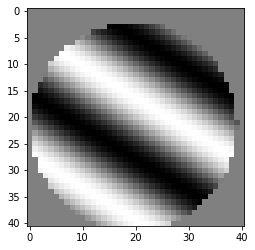

In [30]:
# choose unti idx
unit_idx = 12

# have a look at the stimulus that we generated for unit 27
cs_opt_unit = circular_gratings_list[unit_idx].get_image_from_params(best_params_cs_list[unit_idx])
plt.imshow(cs_opt_unit, cmap="gray", vmin=-1, vmax=1)

# 3.1.) Create Orientation Tuning curves for each unit separately

In [33]:
best_params_cs_list[0]

{'size_total': 10.912740881404961,
 'orientation_center': 1.6122053103418825,
 'spatial_frequency_center': 0.1944684306241452,
 'phase_center': 1.038104441227387,
 'location_width': 19.51154373958707,
 'location_height': 21.687213707715273,
 'size_center': 1.0,
 'size_surround': 1.0,
 'contrast_center': 1.0,
 'contrast_surround': 0.0,
 'orientation_surround': 0.0,
 'grey_level': 0.0,
 'spatial_frequency_surround': 0.0,
 'phase_surround': 0.0}

In [505]:
# orientation values
N = 30
orientations_center_values = [(n * np.pi) / N for n in range(0, N)]

# Initialize the stimuli sets for each unit
circular_gratings_orient_list = []  # init.

for unit in range(0, n_units):
    circular_gratings = CenterSurround(
        canvas_size = canvas_size,
        sizes_total = FiniteParameter([best_params_cs_list[unit]['size_total']]),
        sizes_center = FiniteParameter([1.0]),                      # no surround
        sizes_surround = FiniteParameter([1.0]),                    # some random value higher than 1.0
        contrasts_center = FiniteParameter([1.0]),                  # optimize for full contrast 
        contrasts_surround = FiniteParameter([0.0]),                # input doesn't matter
        orientations_center = FiniteParameter(orientations_center_values), # orientation from optimal Gabor
        orientations_surround = FiniteParameter([0.0]),             # input doesn't matter
        spatial_frequencies_center = FiniteParameter([best_params_cs_list[unit]['spatial_frequency_center']]),    # spatial freq from optimal Gabor
        phases_center = FiniteParameter([best_params_cs_list[unit]['phase_center']]),               # phase offset from optimal Gabor
        grey_levels = FiniteParameter([0.0]),                       # optimize for grey background
        locations = FiniteParameter([[loc_w[unit], loc_h[unit]]]))  # optimize for model readout position
    
    circular_gratings_orient_list.append(circular_gratings)

In [506]:
# Orientation Tuning experiment

activations_list = {}
activations_unit = np.array([]) 
orientations_center_opt = []
orientations_opt_act = []

for unit in range(0, n_units):
    # find the orientation_center value from the optimization (sanity check)
    orientations_center_opt.append(best_params_cs_list[unit]['orientation_center'])  
    orientations_opt_act.append(values_cs_list[unit])
    
    # show the stimuli with varying orientation to the model and store its response 
    unit_name = "unit_" + str(unit)
    for batch in circular_gratings_orient_list[unit].image_batches(batch_size=100):
        images_batch = np.expand_dims(batch, axis=1)
        images_batch = torch.tensor(images_batch).float()
        activations_batch = model(images_batch, data_key=data_key).detach().numpy().squeeze()[:, unit]
        activations_unit = np.hstack([activations_unit, activations_batch])
    activations_list[unit_name] = activations_unit
    activations_unit = np.array([]) 

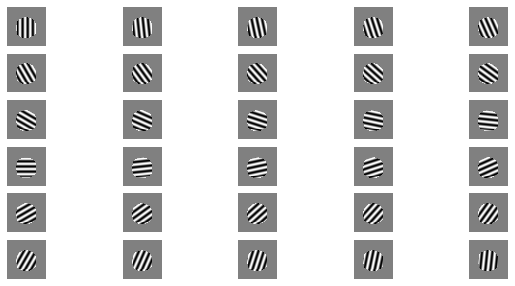

In [507]:
# plot all the stimuli generated for the orientation tuning for unit 0
unit_idx = 0
plt.figure(figsize=(10, 5))

for i, img in enumerate(circular_gratings_orient_list[unit_idx].images()):
    plt.subplot(6, 5, i + 1)
    plt.imshow(img, cmap='gray', vmin=-1, vmax=1)
    plt.axis('off')

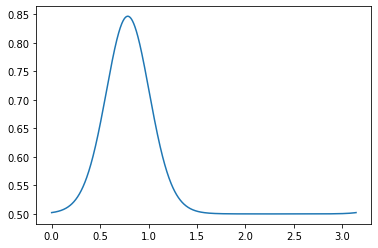

In [508]:
# define the vonMises pdf on support [0, pi)
def vonMises(x, amp, offset, loc, kappa):
    """ von Mises pdf with support on [0, pi) with additional amplitude factor for better fitting. """
    return amp * (np.exp(kappa * np.cos(2*x - loc)) / (np.pi * scipy.special.i0(kappa))) + offset 

# define x range for the fitted von Mises distribution
x_vm = np.linspace(0, np.pi, num=1000)

# plot the pdf of the von Mises 
plt.plot(x_vm, vonMises(x_vm, 0.2, 0.5, np.pi/2, 5))

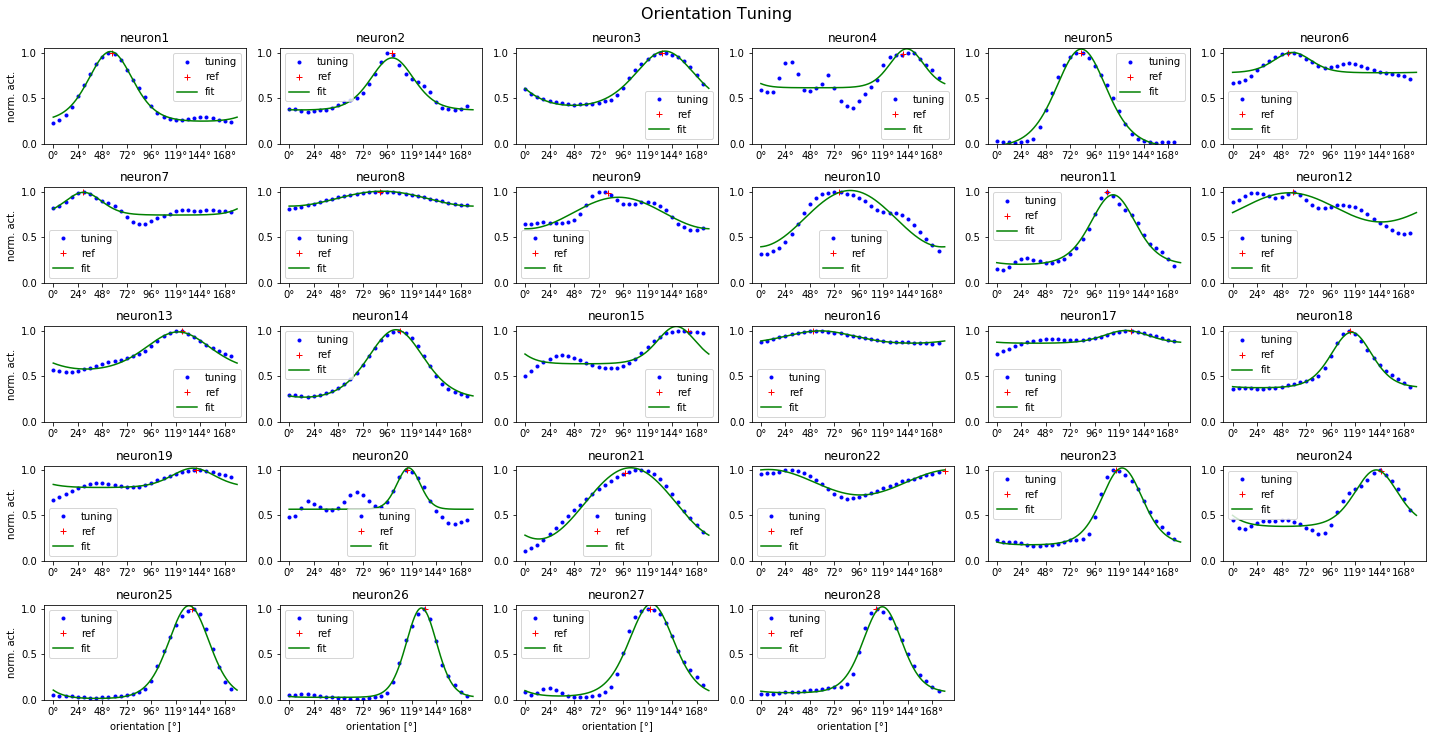

In [510]:
# build orientation tuning curves
max_act_tuning = []  # collect the maximal activation across each units orientations
activations_norm = []  # collect all normalized activations across each units orientations
act_opt_orient_norm = []  # collect the normalized optimal orientation (based on Bayesian search)

# init for fitting
amp_param_list = []  # list of amplitude values of fitted von Mises pdf
offset_param_list = []  # list of offset values of fitted von Mises pdf
loc_param_list = []  # list of location values of fitted von Mises pdf
kappa_param_list = []  # list of kappa values of fitted von Mises pdf

# normalize the neuron responses for each unit and fit a vonMises pdf for each unit
for unit in range(0, n_units):
    
    # normalize the ordinate with max activation
    max_act_tuning.append(np.max(activations_list['unit_' + str(unit)]))  # normalized activations
    activations_norm.append(activations_list['unit_' + str(unit)] / max_act_tuning[unit])
    act_opt_orient_norm.append(orientations_opt_act[unit][0]['activation'] / max_act_tuning[unit])
    
     # fit von Mises distribution to the orientation tunings
    best_vals, _ = curve_fit(vonMises, np.array(orientations_center_values), activations_norm[unit], 
                             p0=[np.random.uniform(0.2, 1.5), 
                                 np.random.uniform(0.1, 0.9),
                                 np.random.normal(2*orientations_center_opt[unit], 0.2), 
                                 np.random.normal(3, 1)],
                             maxfev=1500)
    amp_param_list.append(best_vals[0])
    offset_param_list.append(best_vals[1])
    loc_param_list.append(best_vals[2])
    kappa_param_list.append(best_vals[3])    
    
# prepare figure
rows, cols = 5, 6
fig, ax = plt.subplots(rows, cols, figsize=(20, 10)) # sharex=True, sharey=True
fig.suptitle("Orientation Tuning", fontsize=16, y=1.02)

# plot cosmetics
xticks_orient = orientations_center_values[0::4]
xlabels_orient = [str(int((180 / np.pi) * orient))+"°" for orient in orientations_center_values[0::4]]

unit_idx = 0
for row in range(rows):
    for col in range(cols):
        unit_idx += 1
        if unit_idx > n_units-1:
            ax[row, col].axis('off')
        else:
            # plot the orientation tuning curve
            ax[row, col].plot(orientations_center_values, activations_norm[unit_idx], '.b', label="tuning")
            
            # plot the reference "optimal orientation"
            ax[row, col].plot(orientations_center_opt[unit_idx], act_opt_orient_norm[unit_idx], '+r', label='ref')
            
            # plot the vonMises fit
            ax[row, col].plot(x_vm, vonMises(x_vm,
                                             amp_param_list[unit_idx], 
                                             offset_param_list[unit_idx],
                                             loc_param_list[unit_idx],
                                             kappa_param_list[unit_idx]),
                              'g-', label='fit')
            
            # plot cosmetics
            ax[row, col].set_title('neuron'+str(unit_idx))
            ax[row, col].set_ylim([0.0, 1.05])
            ax[row, col].set_xticks(xticks_orient)
            ax[row, col].set_xticklabels(xlabels_orient)
            ax[row, col].legend(loc='best')
            if col == 0:
                ax[row, col].set_ylabel('norm. act.')
            if row == rows-1: 
                ax[row, col].set_xlabel('orientation [°]')
fig.tight_layout()

Most neurons show a very nice orientation selectivity. The red cross indicates the optimal orientation after optimization with the Bayesian search method. As a sanity check, most of the time the red cross is close to 1 (means very close to the maximum model activation based on the tested orientation tuning values).
For those neurons with sharp and unimodal orientation tuning, the vonMises fit seems quite good as well. 

The fit can then be used easily to calculate FWHM (full-width half-maximum) or MWHM (half-width, half-maximum) quantifications of the tuning strength.

In the literature (e.g. Busse et al.), the tuning curves were fitted with a "circular Gaussian". I did neither find a formula in the Materials&Methods nor in the supplementary material. Thus, I assume that they referred to the vonMises distribution. 

# 3.2.) Contrast Tuning

In [277]:
contrast_values = [0.0, 0.06, 0.12, 0.25, 0.5, 1.0]  # just like in the paper Busse et al

# Initialize the stimuli sets for each unit
circular_gratings_contrast_list = []  # init.

for unit in range(0, n_units):
    circular_gratings = CenterSurround(
        canvas_size = canvas_size,
        sizes_total = FiniteParameter([best_params_cs_list[unit]['size_total']]),
        sizes_center = FiniteParameter([1.0]),                      # no surround
        sizes_surround = FiniteParameter([1.0]),                    # some random value higher than 1.0
        contrasts_center = FiniteParameter(contrast_values),        # optimize for full contrast 
        contrasts_surround = FiniteParameter([0.0]),                # input doesn't matter
        orientations_center = FiniteParameter([best_params_cs_list[unit]['orientation_center']]), # orientation from optimal Gabor
        orientations_surround = FiniteParameter([0.0]),             # input doesn't matter
        spatial_frequencies_center = FiniteParameter([best_params_cs_list[unit]['spatial_frequency_center']]),    # spatial freq from optimal Gabor
        phases_center = FiniteParameter([best_params_cs_list[unit]['phase_center']]),               # phase offset from optimal Gabor
        grey_levels = FiniteParameter([0.0]),                       # optimize for grey background
        locations = FiniteParameter([[loc_w[unit], loc_h[unit]]]))  # optimize for model readout position
    
    circular_gratings_contrast_list.append(circular_gratings)

In [278]:
# show stimuli to the model neurons in batches

# the following code only works if there is just one batch (#stimuli < batch_size)
activations_contrast_list = {}
activations_unit = np.array([]) 

for unit in range(0, n_units):
    unit_name = "unit_" + str(unit)
    
    # show the stimuli with varying orientation to the model and store its response 
    for batch in circular_gratings_contrast_list[unit].image_batches(batch_size=100):
        images_batch = np.expand_dims(batch, axis=1)
        images_batch = torch.tensor(images_batch).float()
        activations_batch = model(images_batch, data_key=data_key).detach().numpy().squeeze()[:, unit]
        activations_contrast_list[unit_name] = activations_batch
        activations_unit = np.hstack([activations_unit, activations_batch])
    activations_list[unit_name] = activations_unit
    activations_unit = np.array([]) 

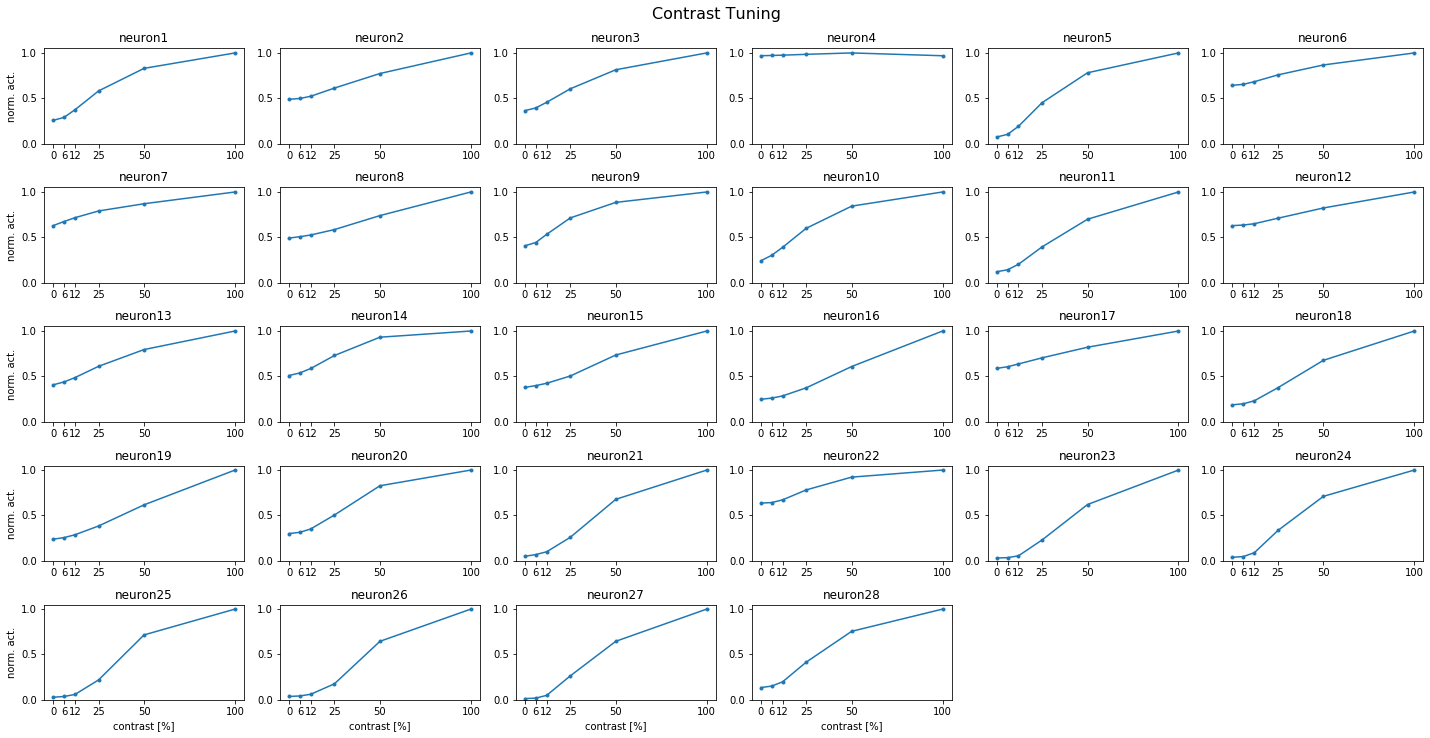

In [503]:
# build contrast tuning curves

# prepare figure
rows, cols = 5, 6
fig, ax = plt.subplots(rows, cols, figsize=(20, 10)) # sharex=True, sharey=True
fig.suptitle("Contrast Tuning", fontsize=16, y=1.02)
xlabels_contrast = [str(int(con * 100)) for con in contrast_values]
xticks_contrast = [con * 100 for con in contrast_values]

unit_idx = 0
for row in range(rows):
    for col in range(cols):
        unit_idx += 1
        if unit_idx > n_units-1:
            ax[row, col].axis('off')
        else:
            max_act = np.max(activations_contrast_list['unit_' + str(unit_idx)])  # normalized activations
            ax[row, col].plot([val * 100 for val in contrast_values], activations_contrast_list['unit_' + str(unit_idx)] / max_act, '.-')
            ax[row, col].set_title('neuron'+str(unit_idx))
            ax[row, col].set_ylim([0.0, 1.05])
            ax[row, col].set_xticks(xticks_contrast)
            ax[row, col].set_xticklabels(xlabels_contrast)
            if col == 0:
                ax[row, col].set_ylabel('norm. act.')
            if row == rows-1: 
                ax[row, col].set_xlabel('contrast [%]')
fig.tight_layout()

Contrast Tuning curves could be fitted with a exponential plateau function of the form $Y(x) = Y_M - (Y_M - Y_0) \cdot \exp \bigl( -k \cdot x \bigr)$. We could initialize the fitting with $Y_M = 1$ and $Y_0 = 0$ and $k$ random in an appropriate range.

It could also be fitting by a hyperbolic ratio function (see Busse et al, 2009, Fig. 1E), supposedly of the form $Y(c) = Y_{max} \cdot \frac{c^n}{c_{50}^{n} +c^n}$, with $c_{50}$ being the semisaturation contrast.

Here, we could further replicate the results from Busse et al. about contrast invariance (see section Contrast-invariance of Population Responses in Results). 

# 4. Plot the circular grating stimuli that we input to the model

As a final feature before we jump into the Plaids-experiments, here is a template to retrieve the stimuli set for a given unit (notice that neuron 1 has unit_idx=0 and so on):

Text(0.5, 0.98, 'Stimuli for neuron 3')

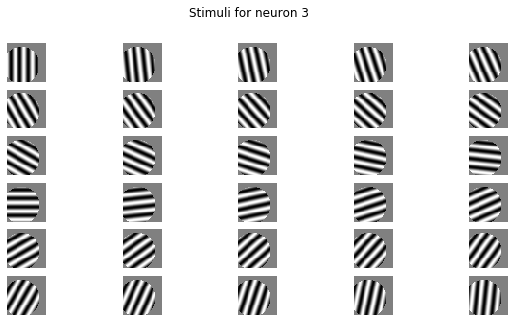

In [293]:
# for orientation tuning

# show the corresponding stimuli for desired unit
unit_idx = 2

fig = plt.figure(figsize=(10, 5))

for i, img in enumerate(circular_gratings_orient_list[unit_idx].images()):
    plt.subplot(6, 5, i + 1)
    plt.imshow(img, cmap='gray', vmin=-1, vmax=1)
    plt.axis('off')
fig.suptitle('Stimuli for neuron ' + str(unit_idx + 1))

Text(0.5, 0.98, 'Stimuli for neuron 4')

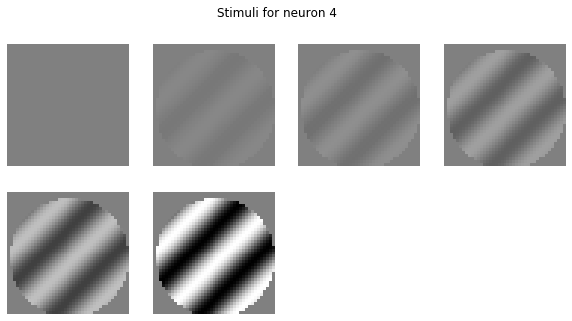

In [294]:
# for contrast tuning

# show the corresponding stimuli for desired unit
unit_idx = 3

fig = plt.figure(figsize=(10, 5))

for i, img in enumerate(circular_gratings_contrast_list[unit_idx].images()):
    plt.subplot(2, 4, i + 1)
    plt.imshow(img, cmap='gray', vmin=-1, vmax=1)
    plt.axis('off')
fig.suptitle('Stimuli for neuron ' + str(unit_idx + 1))

Based on the orientation tuning and contrast tuning curves, we can see that neuron 4 is the only neuron not tuned with respect to contrast. As far as orientation tuning is concerned, we could get rid off neurons 4, 6, 7, 8, 9, 12, 16, 17, 19, 20, 22 for the rest of the analysis. In order to see the effect of overlapping circular grating, it is important for the neurons to show clear orientation selectivity.

4.1) Computing the histogram of orientation preference across units. The binning is 15°, which corresponds to pi/12 in radians.

Text(0.5, 0, 'preferred orientation [rad]')

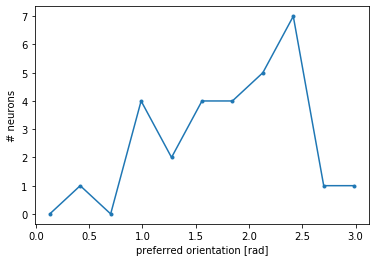

In [307]:
# create a vector with the preferred orientations.
pref_orient_list = [best_params_cs_list[unit]['orientation_center'] for unit in range(0, n_units)]
pref_orient = np.array(pref_orient_list)

# histogram
bin_edges = np.linspace(0, np.pi, 12)
y_hist, x_hist = np.histogram(pref_orient, bins = bin_edges)
bin_center = x_hist[:-1] + np.pi/24
plt.plot(bin_center, y_hist, '.-')
plt.ylabel('# neurons')
plt.xlabel('preferred orientation [rad]')

# 5. Conducting the Plaid Experiments

"The contrast of the gratings was 0%, 6%, 12%, 25%, and 50%. Plaids were obtained by summing two gratings. For each experiment, the angle between component orientations in the plaid was fixed. To reduce effects of adaptation, each experiment consisted of three pairs of orientations (e.g., 0°/90°, 30°/120°, 60°/150°). Data for different pairs were collapsed after adjusting for the difference between stimulus orientation and neuronal preference. In addition, we recorded responses to 100% contrast gratings of 12 different orientations to obtain orientation tuning curves for each site in the array. The stimuli were shown in random order in blocks presented at least eight times." (see suppl mat: https://www.cell.com/neuron/supplemental/S0896-6273(09)00886-1#secd1345349e1602)

"We quantified contrast sensitivity of each neuron by the two parameters of the hyperbolic ratio: semisaturation contrast c50, and exponent n. We then asked whether these parameters are independent of the neuron’s tuning width (halfwidth at half height)." (Busse et al, Fig 2)

In [517]:
# orientation values
N = 30
orientations_center_values = [(n * np.pi) / N for n in range(0, N)]

# define contrast values
contrasts_preferred_values = [0.0, 0.06, 0.12, 0.5]
contrasts_overlap_values = [0.0, 0.12]

# orientation fixed ?
#orientations = FiniteParameter([best_params_cs_list[unit]['orientations_center']]),  # experiment: define orientation values for the tuning curve
#angles_values = [(n * np.pi) / N for n in range(0, N)]


# Initialize the stimuli sets for each unit
plaids_list = []  # init.

for unit in range(0, n_units):
    plaids = PlaidsGratingSet(
        canvas_size = canvas_size,
        sizes_total = FiniteParameter([best_params_cs_list[unit]['size_total']]),            # optimal size
        contrasts_preferred = FiniteParameter(contrasts_preferred_values),                   # experiment: define interesting contrast values
        contrasts_overlap = FiniteParameter(contrasts_overlap_values),                       # experiment: define interesting contrast values
        orientations = FiniteParameter(orientations_center_values),                          # experiment: define orientation values for the tuning curve
        spatial_frequencies = FiniteParameter([best_params_cs_list[unit]['spatial_frequency_center']]), # optimal spatial freq 
        phases = FiniteParameter([best_params_cs_list[unit]['phase_center']]),               # optimal phase offset 
        grey_levels = FiniteParameter([0.0]),                                                # optimize for grey background
        locations = FiniteParameter([[loc_w[unit], loc_h[unit]]]))                           # optimize for model readout position
        #angles = None                                                                       # orthogonal 
    plaids_list.append(plaids)

The stimuli are organized in a way that contrast_preferred=0.0, contrast_overlap=0.0 occupy the first 30 stimuli. Then, contrast_preferred=0.0, contrast_overlap=0.12 occupy the next 30 stimuli. After that, 30 stimuli are generated for the condition contrast_preferred=0.06, contrast_overlap=0.0, and so on. In total, we generated 

In [518]:
# For our 8 experimental condition, which require 30 stimuli each, we generate 8*30=240 images for each neuron

# Example for last unit
np.prod(plaids.num_params())

240

In [519]:
# you can go through all 239 indices to convince yourself that the stimuli are ordered just like explained above
plaids.params_dict_from_idx(29)

{'location': [20.788124247919768, 29.09544451534748],
 'size_total': 16.986468403870315,
 'contrast_preferred': 0.0,
 'contrast_overlap': 0.0,
 'spatial_frequency': 0.07156104869680929,
 'orientation': 3.0368728984701336,
 'phase': 1.9333240549147874,
 'angle': 1.5707963267948966,
 'grey_level': 0.0}

Text(0.5, 1.03, "preferred grating's orientation: 1.5708")

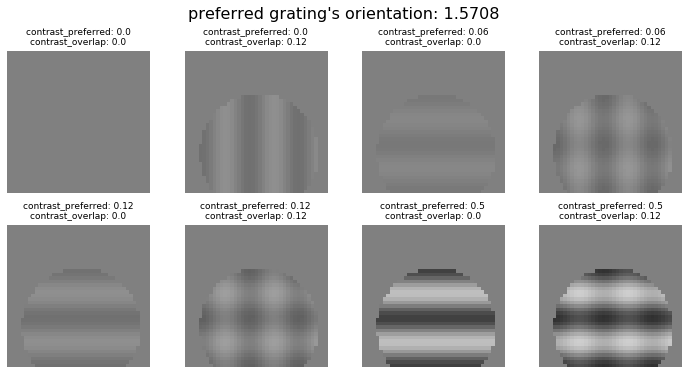

In [520]:
# some stimuli for last unit (compare with Fig.3A from Busse et al.)

fig = plt.figure(figsize=(10, 5))
for cond_idx in range(0, 8):
    img = plaids.stimulus_from_idx(cond_idx*30+15)
    plt.subplot(2, 4, cond_idx + 1)
    plt.imshow(img, cmap='gray', vmin=-1, vmax=1)
    plt.axis('off')
    plt.title('contrast_preferred: {}\ncontrast_overlap: {}'.format(plaids.params_dict_from_idx(cond_idx*30+15)['contrast_preferred'], plaids.params_dict_from_idx(cond_idx*30+15)['contrast_overlap']),
             fontsize=9)
plt.tight_layout()
fig.suptitle("preferred grating's orientation: {}".format(round(plaids.params_dict_from_idx(cond_idx*30+15)['orientation'], 5)), 
             fontsize=16, 
             y=1.03)


In [521]:
# Plaids Experiment - Show images to model neurons

activations_list = {}
activations_unit = np.array([]) 
orientations_center_opt = []
orientations_opt_act = []

for unit in range(0, n_units):
    # show the stimuli with varying orientation to the model and store its response 
    unit_name = "unit_" + str(unit)
    for batch in plaids_list[unit].image_batches(batch_size=100):
        images_batch = np.expand_dims(batch, axis=1)
        images_batch = torch.tensor(images_batch).float()
        activations_batch = model(images_batch, data_key=data_key).detach().numpy().squeeze()[:, unit]
        activations_unit = np.hstack([activations_unit, activations_batch])
    activations_list[unit_name] = activations_unit
    activations_unit = np.array([])  # empty array before going to next unit

Text(0.5, 1.025, 'Neuron26')

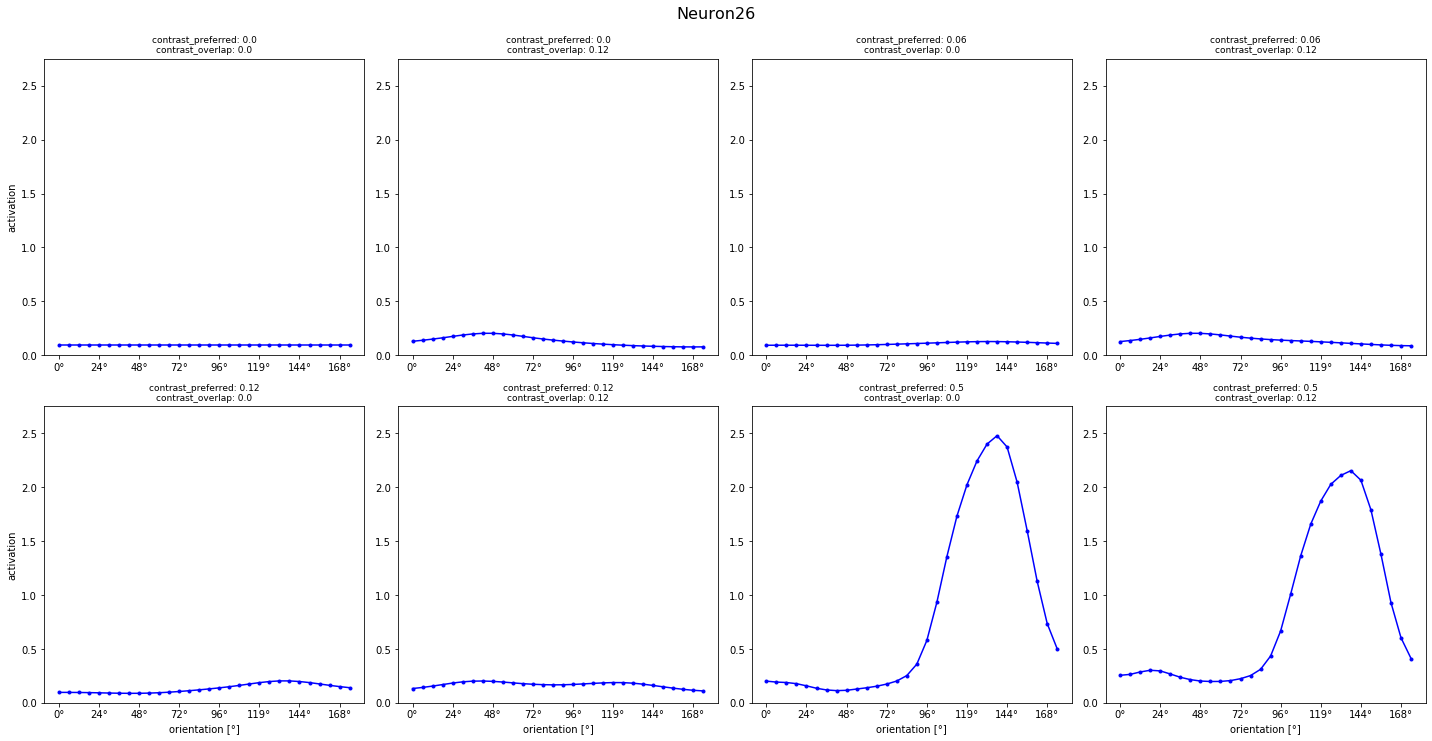

In [527]:
# build orientation tuning curve for each of the 8 conditions for one unit
unit_idx = 25
    
# normalize the ordinate with mean activation
# act_mean = np.mean(activations_list['unit_' + str(unit_idx)])
activations_norm = activations_list['unit_' + str(unit_idx)]  # not normalized

# prepare figure
rows, cols = 2, 4
fig, ax = plt.subplots(rows, cols, figsize=(20, 10)) # sharex=True, sharey=True

# plot cosmetics
xticks_orient = orientations_center_values[0::4]
xlabels_orient = [str(int((180 / np.pi) * orient))+"°" for orient in orientations_center_values[0::4]]

cond_idx = 0
for row in range(rows):
    for col in range(cols):
        if cond_idx > 7:
            ax[row, col].axis('off')
        else:
            # plot the orientation tuning curve
            ax[row, col].plot(orientations_center_values, activations_norm[cond_idx*30:cond_idx*30+30], '.-b')
            
            # plot cosmetics
            ax[row, col].set_title('contrast_preferred: {}\ncontrast_overlap: {}'.format(plaids_list[unit_idx].params_dict_from_idx(cond_idx*30+15)['contrast_preferred'], 
                                                                                         plaids_list[unit_idx].params_dict_from_idx(cond_idx*30+15)['contrast_overlap']), 
                                   fontsize=9)
            ax[row, col].set_ylim([0.0, 2.75])
            ax[row, col].set_xticks(xticks_orient)
            ax[row, col].set_xticklabels(xlabels_orient)
            if col == 0:
                ax[row, col].set_ylabel('activation')
            if row == rows-1: 
                ax[row, col].set_xlabel('orientation [°]')
        cond_idx += 1
fig.tight_layout()
fig.suptitle('Neuron'+str(unit_idx + 1), fontsize=16, y=1.025)

Busse et al was doing the above experiment as a population response. But since my objective is to present the features of the toolbox here, I was not doing that.

Text(0.5, 1.08, 'stimuli for neuron 26,\ncondition: contrast_preferred=0.12, contrast_overlap=0.12')

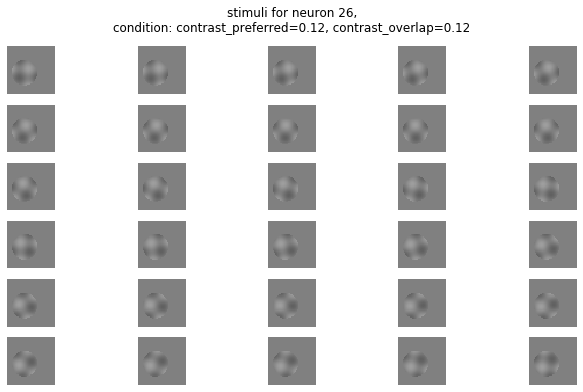

In [537]:
# stimuli for the 12% contrast_preferred and 12% contrast_overlap case for unit 26
unit_idx = 25

fig = plt.figure(figsize=(10, 5))
for orient in range(0, 30):
    img = plaids_list[unit_idx].stimulus_from_idx(150+orient)
    plt.subplot(6, 5, orient+1)
    plt.imshow(img, cmap='gray', vmin=-1, vmax=1)
    plt.axis('off')
plt.tight_layout()
fig.suptitle("stimuli for neuron {},\ncondition: contrast_preferred=0.12, contrast_overlap=0.12".format(unit_idx+1), y=1.08)